In [ ]:
import sqlite3

conn = sqlite3.connect(r"/content/drive/MyDrive/tripadviser.db")
cur = conn.cursor()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
cur.execute("SELECT * FROM hotel_reviews") # 데이터로드
df = pd.DataFrame(cur.fetchall(), columns=['reviews', 'rating'])
cur.close()
conn.close()

print(df.shape)
df.head()

(20491, 2)


,reviews,rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
print(f"중복된 데이터 수 : {df['reviews'].duplicated().sum()} \n")
print(f"""NaN 데이터 수: 
{df.isna().sum()}""")

중복된 데이터 수 : 0 

NaN 데이터 수: 
reviews    0
rating     0
dtype: int64


5    9054
4    6039
3    2184
2    1793
1    1421
Name: rating, dtype: int64


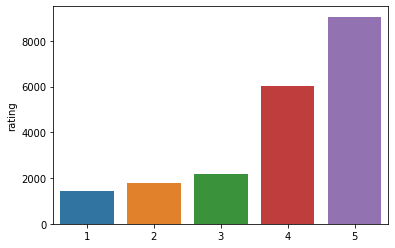

In [ ]:
rating = df['rating'].value_counts()
sns.barplot(x=rating.index, y=rating)
print(rating)

In [ ]:
# 타겟 생성
df['label'] = np.select([df['rating'] > 3], [1], 0) # 평가점수 4점이상 → 긍정리뷰
df.head()

,reviews,rating,label
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1


In [ ]:
# 베이스모델 정확도 확인
df['label'].value_counts(normalize=True)

1    0.736567
0    0.263433
Name: label, dtype: float64

In [ ]:
# 소문자화 & 정규표현식 적용
import re

def lower_and_regex(text):
  text = re.sub(r"[^\w ]", "", text)
  text = text.lower()
  return text

df['reviews'] = df['reviews'].apply(lower_and_regex)
df.head()

,reviews,rating,label
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4 experience hotel monaco seatt...,3,0
3,unique great stay wonderful time hotel monaco ...,5,1
4,great stay great stay went seahawk game awesom...,5,1


In [ ]:
# SpaCy 라이브러리 이용한 불용어처리, 표제어처리
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load('en_core_web_sm')
tokenizer = Tokenizer(nlp.vocab)

def stop_and_lemma(sentences):
  total = []
  i =  0
  for sent in tokenizer.pipe(sentences):
    lemma_sent = []
    for word in sent:
      if (word.is_stop == False) and (word.is_punct ==  False) and (word.pos_ != 'PRON'):
        lem_token = word.lemma_
        lemma_sent.extend(lem_token + ' ')
    sentence = "".join(lemma_sent).rstrip()
    total.append(sentence)
  return total

df['review_lemma_tokens'] = stop_and_lemma(df['reviews'])
df.head()

,reviews,rating,label,review_lemma_tokens
0,nice hotel expensive parking got good deal sta...,4,1,nice hotel expensive park get good deal stay h...
1,ok nothing special charge diamond member hilto...,2,0,okay special charge diamond member hilton deci...
2,nice rooms not 4 experience hotel monaco seatt...,3,0,nice room 4 experience hotel monaco seattle go...
3,unique great stay wonderful time hotel monaco ...,5,1,unique great stay wonderful time hotel monaco ...
4,great stay great stay went seahawk game awesom...,5,1,great stay great stay go seahawk game awesome ...


In [ ]:
!pip install gensim --upgrade # gensim 라이브러리 업데이트 해줘야 원하는 기능 쓸 수 있음

     |████████████████████████████████| 24.1 MB 1.7 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import gensim.downloader as api
# 워드임베딩 사전학습된 값 호출
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
wv.index_to_key[:10]

['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said']

In [ ]:
# 케라스 Tokenizer로 표제어처리된 review 단어별 인덱스화
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(df['review_lemma_tokens'])

for i, key in enumerate(tokenizer.word_index):
  print(key, tokenizer.word_index[key])
  print('--------')
  if i == 5:
    break


print("학습한 단어수 : {}".format(len(tokenizer.word_index)))
print("빈도가 큰 기준으로 보전한 단어수 : 50,000")

hotel 1
--------
room 2
--------
stay 3
--------
great 4
--------
not 5
--------
good 6
--------
학습한 단어수 : 72214
빈도가 큰 기준으로 보전한 단어수 : 50,000


In [ ]:
# 할당된 인덱스로 문장 채우기 
X_encoded = tokenizer.texts_to_sequences(df['review_lemma_tokens'])

for i, sent in enumerate(X_encoded):
  print(f"문장{i} : {sent}")
  print(f"문장 내 단어 수 : {len(sent)}", '\n')
  if i == 2:
    break

문장0 : [9, 1, 190, 102, 25, 6, 213, 3, 1, 829, 89, 127, 198, 51, 679, 476, 55, 676, 102, 53, 375, 153, 36, 225, 2734, 38, 2, 2, 13, 9, 148, 27, 67, 699, 4447, 4064, 167, 390, 1967, 21, 196, 405, 2, 8, 97, 557, 1621, 98, 120, 68, 196, 32, 445, 833, 403, 353, 1622, 2563, 307, 1240, 9, 5914, 3, 9, 374, 51, 925, 3, 108, 12, 4, 15, 212, 86, 164, 9, 83, 173, 74, 884, 102, 8]
문장 내 단어 수 : 82 

문장1 : [116, 266, 182, 1396, 462, 483, 298, 773, 1956, 2237, 829, 510, 208, 34, 130, 74, 180, 359, 2362, 130, 363, 40, 187, 1, 2, 51, 1144, 156, 66, 260, 101, 61, 21, 184, 1423, 3312, 66, 953, 87, 732, 671, 130, 2362, 2979, 359, 1098, 80, 20, 25, 158, 1650, 958, 227, 2, 40, 363, 1241, 2979, 166, 130, 65, 10, 3, 129, 1346, 3570, 1116, 496, 2979, 658, 117, 359, 452, 60, 7163, 199, 130, 1116, 359, 156, 2362, 936, 194, 2262, 156, 5414, 359, 66, 302, 1487, 1938, 3519, 496, 452, 45, 117, 5568, 569, 452, 2539, 559, 87, 645, 9917, 7, 807, 2735, 43, 60, 66, 6, 20, 396, 687, 12293, 87, 1, 10897, 18, 20, 396, 510, 36

In [ ]:
len_sent = []
for sent in X_encoded:
  len_sent.append(len(sent))

print(f"문장 내 최대 단어수 : {np.max(len_sent)}")
print(f"문장 평균 단어수 : {np.mean(len_sent):.2f}")

문장 내 최대 단어수 : 1843
문장 평균 단어수 : 98.76


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


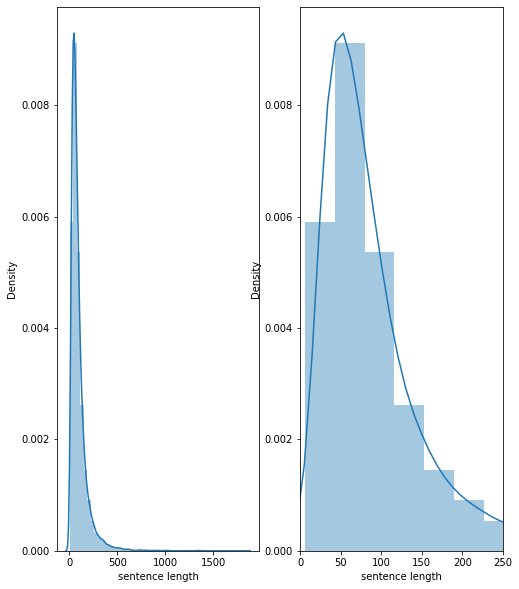

In [ ]:
# 패딩 값 어떻게 할 지 확인
temp = pd.DataFrame(len_sent, columns=['sentence length'])

fig, ax = plt.subplots(1,2, figsize=(8, 10))
sns.distplot(temp['sentence length'], bins=50, ax=ax[0])
sns.distplot(temp['sentence length'], bins=50, ax=ax[1])
ax[1].set_xlim([0, 250])
plt.show()

In [ ]:
# 패딩 고려해서 +1(oov까지 고려할거면 +2)
vocab_size = len(tokenizer.word_index) + 1

# 임베딩벡터 행렬 세팅
embedding_matrix = np.zeros((vocab_size, 300))

def get_vector(word):
  if word in wv:
    embedding_vector = wv[word]
    return embedding_vector
  else:
    return None

# 사용할 임베딩벡터 제작 
for word, index in tokenizer.word_index.items():
  if get_vector(word) is not None:
    embedding_matrix[index] = get_vector(word)

embedding_matrix[:10]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02612305,  0.0144043 , -0.03442383, ...,  0.15625   ,
         0.09960938,  0.12695312],
       [ 0.02624512,  0.1328125 , -0.0234375 , ...,  0.12158203,
        -0.1328125 ,  0.10302734],
       ...,
       [-0.17578125,  0.00098419, -0.00341797, ..., -0.11474609,
        -0.13378906, -0.05834961],
       [ 0.01574707,  0.07666016, -0.03222656, ..., -0.1171875 ,
         0.16894531, -0.05126953],
       [ 0.15820312,  0.10595703, -0.18945312, ..., -0.26757812,
         0.00836182, -0.21386719]])

In [ ]:
# 문장 패딩처리
from tensorflow.keras.preprocessing.sequence import pad_sequences 

x = pad_sequences(X_encoded, maxlen=120, truncating='post', padding='post')
print(f"패딩처리 된 문장 길이 : {len(x[0])}")
x[:10]

패딩처리 된 문장 길이 : 120


array([[    9,     1,   190, ...,     0,     0,     0],
       [  116,   266,   182, ..., 10897,    18,    20],
       [    9,     2,    94, ...,   949,     2,   186],
       ...,
       [   37,     7,   474, ...,     0,     0,     0],
       [    1,     3,     1, ...,     0,     0,     0],
       [   37,     3,     1, ...,     0,     0,     0]], dtype=int32)

In [ ]:
# 데이터분리
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, df['label'], test_size=.2, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape, '\n')

print(x_train[:1])
print(y_train[:1])

(16392, 120) (16392,)
(4099, 120) (4099,) 

[[ 604 1037  152   12   33    3  249   12  465 3160 3877    1  700 1331
    30   53   55   45  768  298   34  337 1710   12  646  207   15 2662
   822  498  142   12  253   13    1    3   20    6  216  612   93  859
   445  870  612    7  604   31 1594  269  142  289  939  182  312  242
   533  132   25  465  138  176  670    1  948  126   49   45 1213  767
  3160 3877  465    1    3   24  465 1625 3160 3877    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
11710    1
Name: label, dtype: int64


In [ ]:
# 감정분석 예측모델 개발
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, LSTM
from tensorflow.keras.models import Sequential, Model

lstm = Sequential()
lstm.add(Embedding(vocab_size, 300, input_length=120, weights=[embedding_matrix], trainable=False))
lstm.add(LSTM(128))
#model.add(GlobalAveragePooling1D())
lstm.add(Dense(64, activation='relu'))
lstm.add(Dense(32, activation='relu'))
lstm.add(Dense(16, activation='relu'))
lstm.add(Dense(1, activation='sigmoid'))

lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 300)          21664500  
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 21,895,029
Trainable params: 230,529
Non-t

In [ ]:
import tensorflow as tf

lstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(
                                              monitor='val_loss',
                                              min_delta=0.001,
                                              patience=10,
                                              verbose=1
                                              )

save_best = tf.keras.callbacks.ModelCheckpoint(
                                               filepath='lstm_best.hdf5',
                                               monitor='val_loss',
                                               verbose=1,
                                               save_best_only=True,
                                               save_weights_only=True,
                                               mode='auto',
                                               save_freq='epoch',
                                               options=None
                                              )

result_lstm = lstm.fit(x_train, y_train,
          epochs=100,
          batch_size=32,
          validation_split=.2,
          callbacks=[early_stop, save_best])

Epoch 1/100
410/410 [==============================] - ETA: 0s - loss: 0.5857 - accuracy: 0.7281
Epoch 1: val_loss improved from inf to 0.56453, saving model to lstm_best.hdf5
410/410 [==============================] - 173s 391ms/step - loss: 0.5857 - accuracy: 0.7281 - val_loss: 0.5645 - val_accuracy: 0.7399
Epoch 2/100
410/410 [==============================] - ETA: 0s - loss: 0.4273 - accuracy: 0.8114
Epoch 2: val_loss improved from 0.56453 to 0.31241, saving model to lstm_best.hdf5
410/410 [==============================] - 102s 248ms/step - loss: 0.4273 - accuracy: 0.8114 - val_loss: 0.3124 - val_accuracy: 0.8737
Epoch 3/100
410/410 [==============================] - ETA: 0s - loss: 0.2842 - accuracy: 0.8864
Epoch 3: val_loss improved from 0.31241 to 0.29095, saving model to lstm_best.hdf5
410/410 [==============================] - 102s 249ms/step - loss: 0.2842 - accuracy: 0.8864 - val_loss: 0.2909 - val_accuracy: 0.8826
Epoch 4/100
410/410 [==============================] - ETA:

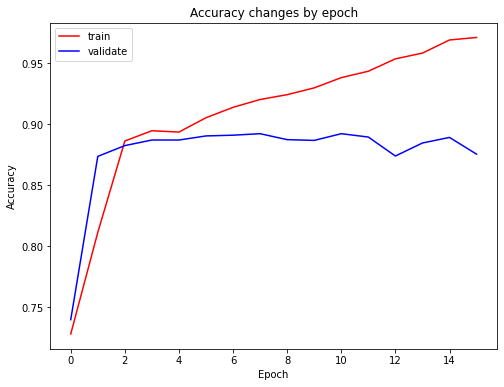

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(result_lstm.history['accuracy'], c='r', label='train')
plt.plot(result_lstm.history['val_accuracy'], c='b', label='validate')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy changes by epoch')
plt.show()

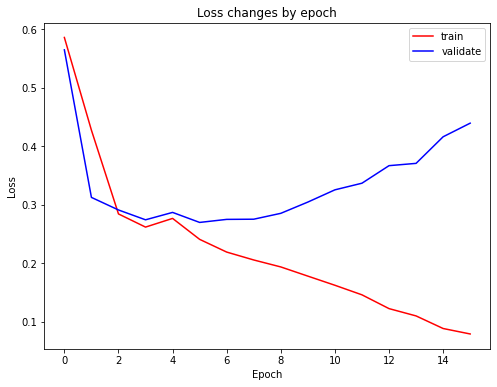

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(result_lstm.history['loss'], c='r', label='train')
plt.plot(result_lstm.history['val_loss'], c='b', label='validate')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss changes by epoch')
plt.show()

In [ ]:
# 감정분석 예측모델 개발
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, LSTM
from tensorflow.keras.models import Sequential, Model

global_avg = Sequential()
global_avg.add(Embedding(vocab_size, 300, input_length=120, weights=[embedding_matrix], trainable=False))
global_avg.add(GlobalAveragePooling1D())
global_avg.add(Dense(64, activation='relu'))
global_avg.add(Dense(32, activation='relu'))
global_avg.add(Dense(16, activation='relu'))
global_avg.add(Dense(1, activation='sigmoid'))

global_avg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 300)          21664500  
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 64)                19264     
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                      

In [ ]:
global_avg.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stop_global_avg = tf.keras.callbacks.EarlyStopping(
                                              monitor='val_loss',
                                              min_delta=0.001,
                                              patience=10,
                                              verbose=1
                                              )

save_best_global_avg = tf.keras.callbacks.ModelCheckpoint(
                                               filepath='global_avg_best.hdf5',
                                               monitor='val_loss',
                                               verbose=1,
                                               save_best_only=True,
                                               save_weights_only=True,
                                               mode='auto',
                                               save_freq='epoch',
                                               options=None
                                              )

result_global_avg = global_avg.fit(x_train, y_train,
          epochs=100,
          batch_size=32,
          validation_split=.2,
          callbacks=[early_stop_global_avg, save_best_global_avg])

Epoch 1/100
403/410 [============================>.] - ETA: 0s - loss: 0.4361 - accuracy: 0.8074
Epoch 1: val_loss improved from inf to 0.36094, saving model to global_avg_best.hdf5
410/410 [==============================] - 3s 7ms/step - loss: 0.4361 - accuracy: 0.8077 - val_loss: 0.3609 - val_accuracy: 0.8515
Epoch 2/100
401/410 [============================>.] - ETA: 0s - loss: 0.3358 - accuracy: 0.8616
Epoch 2: val_loss improved from 0.36094 to 0.33273, saving model to global_avg_best.hdf5
410/410 [==============================] - 2s 6ms/step - loss: 0.3359 - accuracy: 0.8619 - val_loss: 0.3327 - val_accuracy: 0.8634
Epoch 3/100
399/410 [============================>.] - ETA: 0s - loss: 0.3190 - accuracy: 0.8678
Epoch 3: val_loss improved from 0.33273 to 0.31667, saving model to global_avg_best.hdf5
410/410 [==============================] - 3s 7ms/step - loss: 0.3186 - accuracy: 0.8679 - val_loss: 0.3167 - val_accuracy: 0.8695
Epoch 4/100
402/410 [============================>.] 

In [ ]:
!ls

drive  global_avg_best.hdf5  lstm_best.hdf5  sample_data


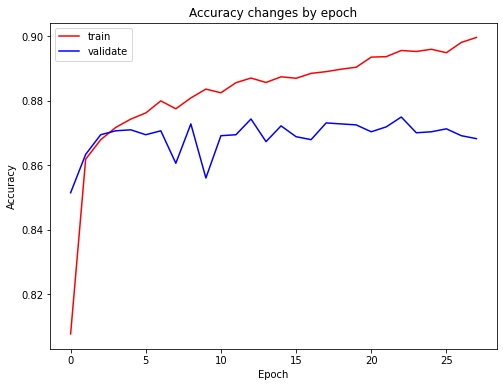

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(result_global_avg.history['accuracy'], c='r', label='train')
plt.plot(result_global_avg.history['val_accuracy'], c='b', label='validate')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy changes by epoch')
plt.show()

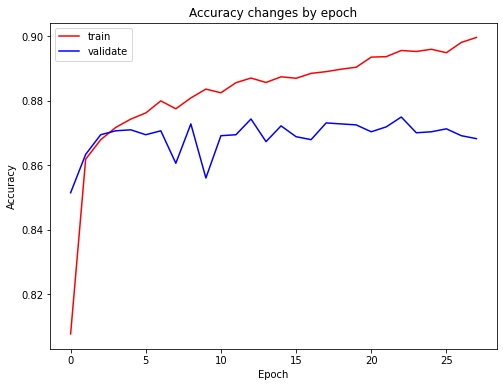

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(result_global_avg.history['accuracy'], c='r', label='train')
plt.plot(result_global_avg.history['val_accuracy'], c='b', label='validate')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy changes by epoch')
plt.show()

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

lstm.load_weights('lstm_best.hdf5')
test_loss, test_acc = lstm.evaluate(x_test, y_test, verbose=1)
print(f"\n lstm_test_accuracy : {test_acc:.2f} \n")


global_avg.load_weights('global_avg_best.hdf5')
test_loss_global_avg, test_acc_global_avg = global_avg.evaluate(x_test, y_test, verbose=1)
print(f"\n global_avg_test_accuracy : {test_acc_global_avg:.2f}")

129/129 [==============================] - 10s 80ms/step - loss: 0.2509 - accuracy: 0.9002

 lstm_test_accuracy : 0.90 

129/129 [==============================] - 1s 5ms/step - loss: 0.2766 - accuracy: 0.8829

 global_avg_test_accuracy : 0.88


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


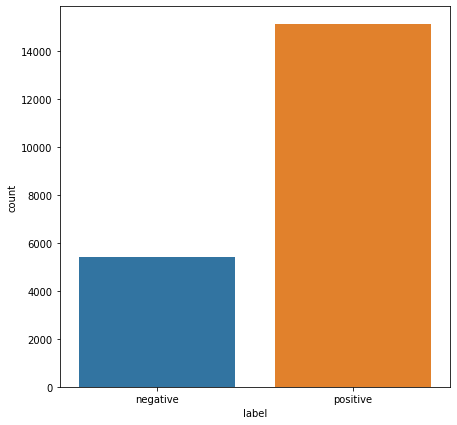


 베이스 모델 accuracy : 0.74

 LSTM 모델 accuracy : 0.90

 GlobalAvg 모델 accuracy : 0.88


In [ ]:
# 베이스 모델 성능(모두 positive로 예측)
fig, ax = plt.subplots(ncols=1, figsize=(7,7))
ax.plot(1)

sns.countplot(df['label'])
plt.xticks([0,1], ['negative', 'positive'])
plt.show()
print(f"\n 베이스 모델 accuracy : {df['label'].value_counts(normalize=True)[1]:.2f}")
print(f"\n LSTM 모델 accuracy : {lstm.evaluate(x_test, y_test, verbose=0)[1]:.2f}")
print(f"\n GlobalAvg 모델 accuracy : {global_avg.evaluate(x_test, y_test, verbose=0)[1]:.2f}")

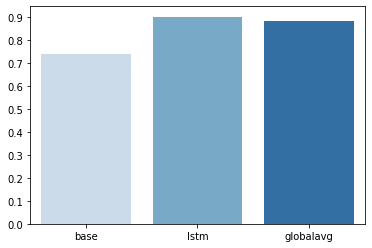

In [ ]:
sns.barplot(x=['base', 'lstm', 'globalavg'], y=[df['label'].value_counts(normalize=True)[1], lstm.evaluate(x_test, y_test, verbose=0)[1], global_avg.evaluate(x_test, y_test, verbose=0)[1]], palette='Blues')
plt.yticks(np.arange(0., 1., .1))
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold

stkf = StratifiedKFold(n_splits=5)

train_accs = []
val_accs = []
train_losses = []
val_losses = []

i = 0
for train_idx, val_idx in stkf.split(x, df['label']):
  x = pd.DataFrame(x)
  x_train = x.iloc[train_idx] 
  y_train = df[['label']].iloc[train_idx]
  x_val = x.iloc[val_idx] 
  y_val = df[['label']].iloc[val_idx]
  if i == 0:
    print(f"train data shpae 확인 : {x_train.shape}, {y_train.shape}")
    print(f"val data shpae 확인 : {x_val.shape}, {y_val.shape}")
    i += 1
  else:
    pass
  train_loss, train_acc = lstm.evaluate(x_train, y_train, verbose=1)
  val_loss, val_acc = lstm.evaluate(x_val, y_val, verbose=1)
  train_accs.append(train_acc)
  val_accs.append(val_acc)
  train_losses.append(train_loss)
  val_losses.append(val_loss)

print(train_accs)
print(val_accs)
print(train_losses)
print(val_losses)

train data shpae 확인 : (16392, 120), (16392, 1)
val data shpae 확인 : (4099, 120), (4099, 1)
129/129 [==============================] - 10s 77ms/step - loss: 0.2225 - accuracy: 0.9109
[0.9074548482894897, 0.9088025093078613, 0.9083755016326904, 0.9086805582046509, 0.9074605107307434]
[0.9109538793563843, 0.9055637121200562, 0.9072718620300293, 0.906051754951477, 0.910932183265686]
[0.23024311661720276, 0.22815121710300446, 0.22846782207489014, 0.23095926642417908, 0.23178726434707642]
[0.22863580286502838, 0.23700425028800964, 0.23573806881904602, 0.22577150166034698, 0.2224593311548233]


In [ ]:
print(f"train_set 평균 정확도 : {np.mean(train_accs).round(2)}")
print(f"validate_set 평균 정확도 : {np.mean(val_accs).round(2)} \n")
print(f"train_set 평균 손실 : {np.mean(train_losses).round(2)}")
print(f"validate_set 평균 손실 : {np.mean(val_losses).round(2)}")

train_set 평균 정확도 : 0.91
validate_set 평균 정확도 : 0.91 

train_set 평균 손실 : 0.23
validate_set 평균 손실 : 0.23


In [ ]:
test1 = "I am happy to be with this hotel"
test2 = "It is worth coming once a year"
test3 = "The room was very bad"
test4 = "Not good"
sentences = [test1, test2, test3, test4]

In [ ]:
# 고객들의 문자열 리뷰 > 인덱스화 + 패딩처리 함수
def to_sequence(sentences):
  sentence_list = []
  for sent in sentences:
    sent = lower_and_regex(sent)
    sentence_list.append(sent)

  sents_encoded = tokenizer.texts_to_sequences(sentence_list)
  x = pad_sequences(sents_encoded, maxlen=120, truncating='post', padding='post')
  return x

test_review = to_sequence(sentences)
results = lstm.predict(test_review)
for i in range(len(results)):
  print(f"test{i+1} : 긍정확률 {results[i][0] * 100:.2f}%의 리뷰 작성하였습니다.")
  if results[i][0] > 0.6:
    print('\t\t\t\t\t 최종 감정: 긍정 \n')
  elif results[i][0] > 0.4:
    print('\t\t\t\t\t 최종 감정: 중립 \n')
  else:
    print('\t\t\t\t\t 최종 감정: 부정 \n')

test1 : 긍정확률 83.27%의 리뷰 작성하였습니다.
					 최종 감정: 긍정 

test2 : 긍정확률 45.46%의 리뷰 작성하였습니다.
					 최종 감정: 중립 

test3 : 긍정확률 4.74%의 리뷰 작성하였습니다.
					 최종 감정: 부정 

test4 : 긍정확률 37.00%의 리뷰 작성하였습니다.
					 최종 감정: 부정 



In [ ]:
# 개발한 모델저장
import pickle

with open('model.pkl', 'wb') as model_file:
  pickle.dump(lstm, model_file)

INFO:tensorflow:Assets written to: ram://10370f9a-77c6-4c36-8bbd-07c6a35b2981/assets


INFO:tensorflow:Assets written to: ram://10370f9a-77c6-4c36-8bbd-07c6a35b2981/assets


In [ ]:
#  개발에 활용한 라이브러리 + 코랩에 내장된 라이브러리 목록저장
!pip freeze > requirements.txt